# Extract time series from a published figure

Scott Cole

29 July 2016

## Summary

Sometimes we might be interested in obtaining a precise estimate of the results published in a figure. Instead of zooming in a ton on the figure and manually taking notes, here we use some simple image processing to extract the data that we're interested in.

## Example Case

We're looking at [a recent Neuron paper](http://www.sciencedirect.com/science/article/pii/S0896627315004134) that highlighted a potential top-down projection from motor cortex (M2) to primary somatosensory cortex (S1). This interaction is summarized in the firing rate curves below:
<img src="files/figure_raw.png">

If we were interested in modeling this interaction, then we may want to closely replicate the firing rate dynamics of S1. So in this notebook, we extract this time series from the figure above so that we can use it for future model fitting.

## Step 1

In our favorite image editting software (or simply MS Paint), we can isolate the curve we are interested in as well as the scale bars (separated by whitespace)
<img src="files/figure_processed.png">

## Step 2: Convert image to binary

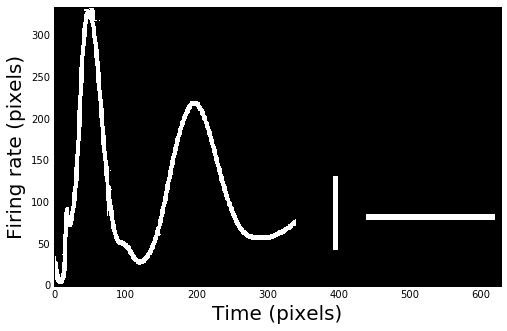

In [1]:
# Load image and libraries
%matplotlib inline
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
from scipy import misc
input_image = misc.imread('figure_processed.png')

# Convert input image from RGBA to binary
input_image = input_image - 255
input_image = np.mean(input_image,2)
binary_image = input_image[::-1,:]
binary_image[binary_image>0] = 1
Npixels_rate,Npixels_time = np.shape(binary_image)

# Visualize binary image
plt.figure(figsize=(8,5))
plt.pcolor(np.arange(Npixels_time),np.arange(Npixels_rate),binary_image, cmap=cm.bone)
plt.xlim((0,Npixels_time))
plt.ylim((0,Npixels_rate))
plt.xlabel('Time (pixels)',size=20)
plt.ylabel('Firing rate (pixels)',size=20)

## Step 3. Project 2-D binary image to 1-D time series

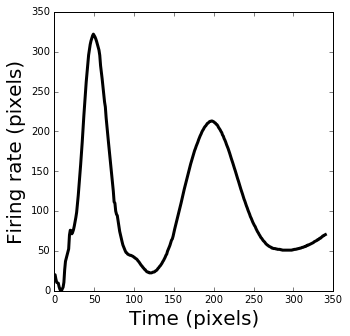

In [2]:
# Extract the time series (not the scale bars) by starting in the first column
col_in_time_series = True
s1rate_pixels = []
col = 0
while col_in_time_series == True:
    if len(np.where(binary_image[:,col]==1)[0]):
        s1rate_pixels.append(np.mean(np.where(binary_image[:,col]==1)[0]))
    else:
        col_in_time_series = False
    col += 1
s1rate_pixels = np.array(s1rate_pixels)

# Subtract baseline
s1rate_pixels = s1rate_pixels - np.min(s1rate_pixels)

# Visualize time series
plt.figure(figsize=(5,5))
plt.plot(s1rate_pixels,'k',linewidth=3)
plt.xlabel('Time (pixels)',size=20)
plt.ylabel('Firing rate (pixels)',size=20)

## Step 4. Rescale in x- and y- variables

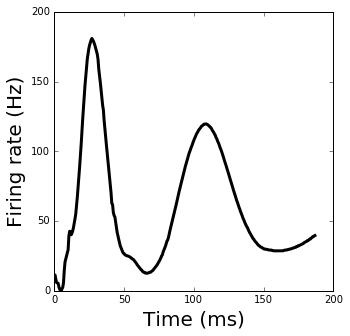

In [3]:
# Convert rate from pixels to Hz
ratescale_col = 395 # Column in image containing containing rate scale
rate_scale = 50 # Hz, scale in image
ratescale_Npixels = np.sum(binary_image[:,ratescale_col])
pixels_to_rate = rate_scale/ratescale_Npixels
s1rate = s1rate_pixels*pixels_to_rate

# Convert time from pixels to ms
timescale_row = np.argmax(np.mean(binary_image[:,400:],1)) # Row in image containing time scale
time_scale = 100 # ms, scale in image
timescale_Npixels = np.sum(binary_image[timescale_row,400:])
pixels_to_time = time_scale/timescale_Npixels
pixels = np.arange(len(s1rate_pixels))
t = pixels*pixels_to_time

# Visualize re-scaled time series
plt.figure(figsize=(5,5))
plt.plot(t, s1rate,'k',linewidth=3)
plt.xlabel('Time (ms)',size=20)
plt.ylabel('Firing rate (Hz)',size=20)

## Step 5. Resample at desired sampling rate

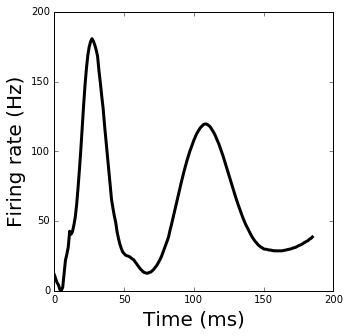

In [4]:
# Interpolate time series to sample every 1ms
from scipy import interpolate
f = interpolate.interp1d(t, s1rate) # Set up interpolation
tmax = np.floor(t[-1])
t_ms = np.arange(tmax) # Desired time series, in ms
s1rate_ms = f(t_ms) # Perform interpolation

# Visualize re-scaled time series
plt.figure(figsize=(5,5))
plt.plot(t_ms, s1rate_ms,'k',linewidth=3)
plt.xlabel('Time (ms)',size=20)
plt.ylabel('Firing rate (Hz)',size=20)

# Save final time series
np.save('extracted_timeseries',s1rate_ms)